# Mineração de Dados - Trabalho Prático

- **Aluna:** Bárbara Neves
- **Matrícula:** 388713

## Descrição do Trabalho

***Toxic Comment Classification*: Identifique e classifique comentários "tóxicos"**, foi retirado das competições da Plataforma *Kaggle* e se trata de um problema de Regressão e Processamento de Linguagem Natural (LPN).

O objetivo é criar um *multi-headed model* capaz de detectar diferentes tipos de comentários tóxicos, como os que possuem ameaças, obscenidade, insultos e ódio baseado em identidade. 

Este modelo deve prever a **probabilidade** de comportamento tóxico para cada comentário.

## Imports Iniciais

In [328]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Leitura e Exploração dos Dados 

In [329]:
df_train = pd.read_csv('Dataset/train.csv')

df1 = pd.read_csv('Dataset/test.csv')
df2 = pd.read_csv('Dataset/test_labels.csv')

df_test = pd.merge(df1, df2, on='id')

In [330]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Colocar explicação aqui sobre os dados de treino

In [331]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


### Valores Faltantes

In [332]:
print("Quantidade de valores faltantes nos dados de treino:")
df_train.isna().sum()

Quantidade de valores faltantes nos dados de treino:


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [333]:
print("Quantidade de valores faltantes nos dados de teste:")
df_test.isna().sum()

Quantidade de valores faltantes nos dados de teste:


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Como verificado anteriormente, não existem valores faltantes. Entretanto, podem existir comentários com campos "nulos". 

### Comentários Nulos

In [334]:
coment_nulo = {}
coment_nulo['Treino'] = {'Quantidade' : len(df_train[df_train['comment_text'].isnull()])}
coment_nulo['Teste'] = {'Quantidade' : len(df_test[df_test['comment_text'].isnull()])}

print("Comentários nulos nos dados de:")
for key in coment_nulo :
    print(str(key) + ' = ' + str(coment_nulo[key]['Quantidade']))

Comentários nulos nos dados de:
Treino = 0
Teste = 0


Explicação

### Comentários Sem Classificação

In [335]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Percebe-se que os valores médios (*mean*) são muito pequenos (um pouco abaixo de 0.05). Aparentemente, muitos comentários não são rotulados em nenhuma das seis categorias.

In [336]:
df_train.shape, df_test.shape

((159571, 8), (153164, 8))

In [337]:
labels = ['obscene', 'insult', 'toxic', 'severe_toxic', 'identity_hate', 'threat']
coments_unlabel = df_train[(df_train['toxic'] != 1) & (df_train['severe_toxic'] != 1) & (df_train['obscene'] != 1) & 
                      (df_train['threat'] != 1) & (df_train['insult'] != 1) & (df_train['identity_hate'] != 1)]

print('Percentual de comentários sem classificação: ', str(len(coments_unlabel) / len(df_train)*100) + 
      '%\nQuantidade de comentários de cada categoria:')
print(df_train[labels].sum())

Percentual de comentários sem classificação:  89.83211235124176%
Quantidade de comentários de cada categoria:
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


### Quantidade de Caracteres por Comentário

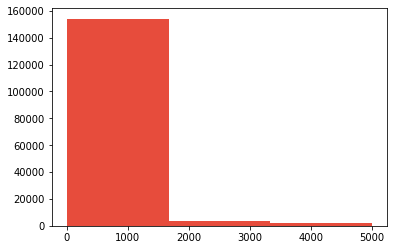

In [338]:
df_train_novo = df_train
df_train_novo['number_of_char'] = df_train['comment_text'].apply(lambda x: len(str(x)))

hist = plt.hist(df_train['number_of_char'], bins=3, color='#e74c3c')

plt.show()

In [339]:
df_train_novo.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_of_char
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


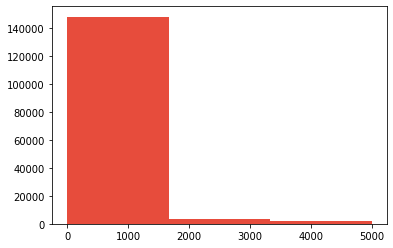

In [340]:
df_test_novo = df_test
df_test_novo['number_of_char'] = df_test['comment_text'].apply(lambda x: len(str(x)))

hist = plt.hist(df_test['number_of_char'], bins=3, color='#e74c3c')

plt.show()

In [341]:
df_test_novo.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_of_char
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1,54
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1,205
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1,41


### Correlação

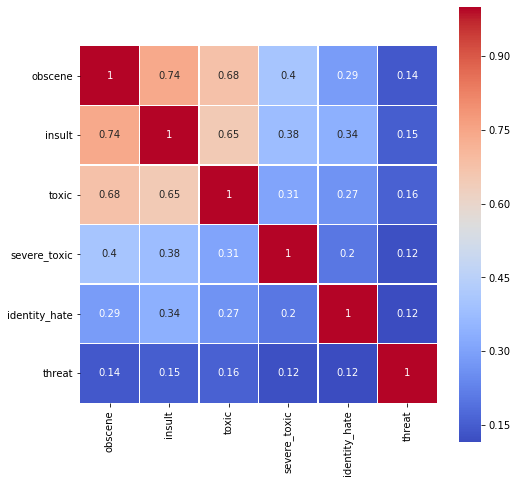

In [342]:
data = df_train[labels]

colormap = plt.cm.coolwarm
plt.figure(figsize = (8,8))

sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', 
            annot=True);

Explicação

## Pré-Processamento dos Dados

### Modificando Valor da Pontuação dos Dados de Teste

In [344]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_of_char
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1,54
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1,205
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1,41


In [345]:
df_test.loc[df_test.toxic == -1, 'toxic'] = 0
df_test.loc[df_test.severe_toxic == -1, 'severe_toxic'] = 0
df_test.loc[df_test.obscene == -1, 'obscene'] = 0
df_test.loc[df_test.threat == -1, 'threat'] = 0
df_test.loc[df_test.insult == -1, 'insult'] = 0
df_test.loc[df_test.identity_hate == -1, 'identity_hate'] = 0

In [346]:
df_test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,number_of_char
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0,0,0,0,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0,54
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0,0,0,0,205
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0,0,0,0,41


### Padronizando os Comentários

In [271]:
df_train['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
5         "\n\nCongratulations from me as well, use the ...
6              COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7         Your vandalism to the Matt Shirvington article...
8         Sorry if the word 'nonsense' was offensive to ...
9         alignment on this subject and which are contra...
10        "\nFair use rationale for Image:Wonju.jpg\n\nT...
11        bbq \n\nbe a man and lets discuss it-maybe ove...
12        Hey... what is it..\n@ | talk .\nWhat is it......
13        Before you start throwing accusations and warn...
14        Oh, and the girl above started her arguments w...
15        "\n\nJuelz Santanas Age\n\nIn 2002, Juelz Sant...
16        Bye! \n\nDon't look, come or t

In [280]:
df_test['comment_text']

0         yo bitch ja rule is more succesful then you'll...
1         == from rfc == \n\n the title is fine as it is...
2         " \n\n == sources == \n\n * zawe ashton on lap...
3         :if you have a look back at the source, the in...
4                 i don't anonymously edit articles at all.
5         thank you for understanding. i think very high...
6         please do not add nonsense to wikipedia. such ...
7                          :dear god this site is horrible.
8         " \n only a fool can believe in such numbers. ...
9         == double redirects == \n\n when fixing double...
10        i think its crap that the link to roggenbier i...
11        "::: somebody will invariably try to add relig...
12        , 25 february 2010 (utc) \n\n :::looking it ov...
13        " \n\n it says it right there that it is a typ...
14        " \n\n == before adding a new product to the l...
15        ==current position== \n anyone have confirmati...
16                                 this 

In [274]:
import re

In [281]:
#Função de padronização

def padroniza_texto(texto):
    
    texto = texto.encode('ascii', errors = 'ignore').decode() #Decodificando caracteres em ASCII
    texto = texto.lower() #Apenas caracteres minúsculos
    texto = re.sub(r'http\S+', ' ', texto) #Evitando links
    texto = re.sub(r'#+', ' ', texto)
    texto = re.sub(r'@[A-Za-z0-9]+', ' ', texto)
    texto = re.sub(r"([A-Za-z]+)'s", r"\1 is", texto)
    texto = re.sub(r"what's", "what is ", texto) #Evitando contrações
    texto = re.sub(r"\'s", " ", texto) #Evitando contrações
    texto = re.sub(r"won't", "will not ", texto) #Evitando contrações
    texto = re.sub(r"\'ve", " have ", texto) #Evitando contrações
    texto = re.sub(r"can't", "can not ", texto) #Evitando contrações
    texto = re.sub(r"n't", " not ", texto) #Evitando contrações
    texto = re.sub(r"isn't", "is not ", texto) #Evitando contrações
    texto = re.sub(r"i'm", "i am ", texto) #Evitando contrações
    texto = re.sub(r"\'re", " are ", texto) #Evitando contrações
    texto = re.sub(r"\'d", " would ", texto) #Evitando contrações
    texto = re.sub(r"\'ll", " will ", texto) #Evitando contrações
    texto = re.sub(r"\'scuse", " excuse ", texto) #Evitando contrações
    texto = re.sub('\W', ' ', texto)
    texto = re.sub('\s+', ' ', texto)
    texto = re.sub(r'\d+', ' ', texto)
    texto = texto.strip(' ') #Removendo espaços do começo e fim 
    
    return texto

In [282]:
df_train['comment_text'] = df_train['comment_text'].map(lambda coment : padroniza_texto(coment))
df_test['comment_text'] = df_test['comment_text'].map(lambda coment : padroniza_texto(coment))

In [287]:
df_train['comment_text'].head()

0    explanation why the edits made under my userna...
1    d aww he matches this background colour i am s...
2    hey man i am really not trying to edit war it ...
3    more i can not make any real suggestions on im...
4    you sir are my hero any chance you remember wh...
Name: comment_text, dtype: object

In [288]:
df_test['comment_text'].head()

0    yo bitch ja rule is more succesful then you wi...
1              from rfc the title is fine as it is imo
2                       sources zawe ashton on lapland
3    if you have a look back at the source the info...
4            i do not anonymously edit articles at all
Name: comment_text, dtype: object

## Resolvendo o Problema de *Multi-label Classification*

### Separando os X_train e X_test

In [356]:
X_train = df_train['comment_text']
X_test = df_test['comment_text'] 

In [357]:
X_train.shape, X_test.shape

((159571,), (153164,))

In [354]:
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

## Validação do Modelo

In [ ]:
#Usar as métricas do Scikit-learn
#Plotar gráficos
#Fazer comparações